<a href="https://colab.research.google.com/github/risker93/Hello_World/blob/main/2021_06_11_study_%EB%82%98%EC%9D%98%EC%B2%AB%EC%BA%90%EA%B8%80%EB%8F%84%EC%A0%84%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**2019 2nd ML month with KaKR** 을 처음부터 끝까지 직접 해 볼 것입니다.



In [35]:
import xgboost
import lightgbm
import missingno

In [36]:
pip install scikit-learn==0.23.0

대회를 본격적으로 시작하기 전에 소개와 세부내용을 잘 읽고 시작하는것이 좋다.

점수 평가 기준은 **RMSE**

RMSE는 Root Mean Squared Error의 약자, 실제 정답과 예측한 값의 차이의 제곱을 평균한 값의 제곱근

이번 대회에서 푸는 문제는 분류일까 회귀일까?

어떤 카테고리에 속하는지 맞추는 문제가 아니라, 실수값을 맞추는 문제이므로 회귀이다.

대회 규칙을 잘 확인해 보도록 하자.



# 데이터 살펴보기

데이터를 잘 이해할 수록, 더 좋은 결과가 나온다.

**File descriptions**

train.csv - 예측 모델을 만들기 위해 사용하는 학습 데이터입니다. 집의 정보와 예측할 변수인 가격(Price) 변수를 가지고 있습니다.

test.csv - 학습셋으로 만든 모델을 가지고 예측할 가격(Price) 변수를 제외한 집의 정보가 담긴 테스트 데이터 입니다.

sample_submission.csv - 제출시 사용할 수 있는 예시 submission.csv 파일입니다.


**Data fields**
ID : 집을 구분하는 번호

date : 집을 구매한 날짜

price : 집의 가격(Target variable)

bedrooms : 침실의 수

bathrooms : 화장실의 수

sqft_living : 주거 공간의 평방 피트(면적)

sqft_lot : 부지의 평방 피트(면적)

floors : 집의 층 수

waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)

view : 집이 얼마나 좋아 보이는지의 정도

condition : 집의 전반적인 상태

grade : King County grading 시스템 기준으로 매긴 집의 등급

sqft_above : 지하실을 제외한 평방 피트(면적)

sqft_basement : 지하실의 평방 피트(면적)

yr_built : 지어진 년도

yr_renovated : 집을 재건축한 년도

zipcode : 우편번호

lat : 위도

long : 경도

sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

다양한 컬럼들을 가지고 있는 데이터다. 우리가 예측해야 하는 컬럼은 price, 즉 집의 가격이다.

데이터 셋 자체에 대한 설명 외에, 우리가 다운받아야 할 데이터 파일의 형태를 살펴봐야 한다.

train.csv 라는 모델학습용, test.csv 라는 테스트용, sample_submission.csv라는 제출용 파일이 제공됨.

우리는 train.csv를 활용해서 데이터를 뜯어보고 모델을 학습시킨후, test파일의 데이터에 대해 price 를 예측해서 sample_submission의 형식에 맞는 형태로 캐글에 제출해 볼 것이다.



In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


파일을 다운로드 받고 드라이브에 올려서 마운트 해주었다.

이번 대회에서는 Baseline 이란걸 제공해주었다.

Baseline으로 빠르게 제출해 보자

Baseline 커널을 다운받아 실행시킨다. (나는 그냥 진행 하도록 한다)

In [38]:
#베이스라인 커널에는 다양한 시각화 코드가 있기 때문에 아래 코드를 실행해 시각화 그래프가 나타날수 있도록 합니다.
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

이제부터 실제 Baseline 커널에 있는 내용입니다.

**필요한 라이브러리 import 하기**
전체 코드를 실행시키는 데에 필요한 모든 라이브러리를 한 번에 가져오는군요.

In [39]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns


주피터로 할 시 우리 경로랑 베이스라인 커널과 경로가 다름 

Baseline 커널은 캐글의 서버에서 돌아가도록 코드가 설계되었기 때문에 데이터가 ../input 이라는 디렉토리에 위치함.

    train_data_path = join('../input', 'train.csv')
    sub_data_path = join('../input', 'test.csv')
    #베이스라인 커널의 기존 코드


In [40]:
data_dir = '/content/drive/MyDrive/data_study_kaggle'
train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv') # 테스트 즉, submission 시 사용할 데이터 경로
print(train_data_path)
print(sub_data_path)

/content/drive/MyDrive/data_study_kaggle/train.csv
/content/drive/MyDrive/data_study_kaggle/test.csv


**데이터 살펴보기**

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아보이는지의 정도 
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방피트(집을 재건축 했다면, 변화가 있을수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축 했다면, 변화가 있을 수 있음)


**데이터 불러오기**

In [41]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


학습 데이터는 1만 5천개, 테스트 데이터는 6천 4백개 로 이루어져 있다.

테스트 데이터에는 우리가 맞추어야 할 집의가격, price가 없기 때문에 컬럼이 하나 적다.


**학습 데이터에서 라벨 제거하기**

price 컬럼은 따로 y라는 변수에 저장한 후 해당 컬럼 삭제

In [42]:
y = data['price']
del data['price']

print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


**학습 데이터와 테스트 데이터 합치기**

모델을 학습 시키기전, 전체 데이터에 대해 탐색해보기 위해 두 데이터를 pd.concat으로 합쳐본다.

모델 학습을 진행할 때에는 다시 분리해서 사용해야 하기 때문에 데이터를 합치기 전 train_len에 training data의 개수를 저장후, 추후 학습데이터만 불러올 수 있는 인덱스로 사용.

In [43]:
len(data)

15035

In [44]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

print(len(data))

21503


axis 는 행의 축 기준, 위아래로 붙음

In [45]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


**간단한 전처리**

빈 데이터와, 전체 데이터의 분포를 확인하는 전처리 작업.

결측치, 즉 빈 데이터가 있는지 missingno 라이브러리를 사용해 확인함.

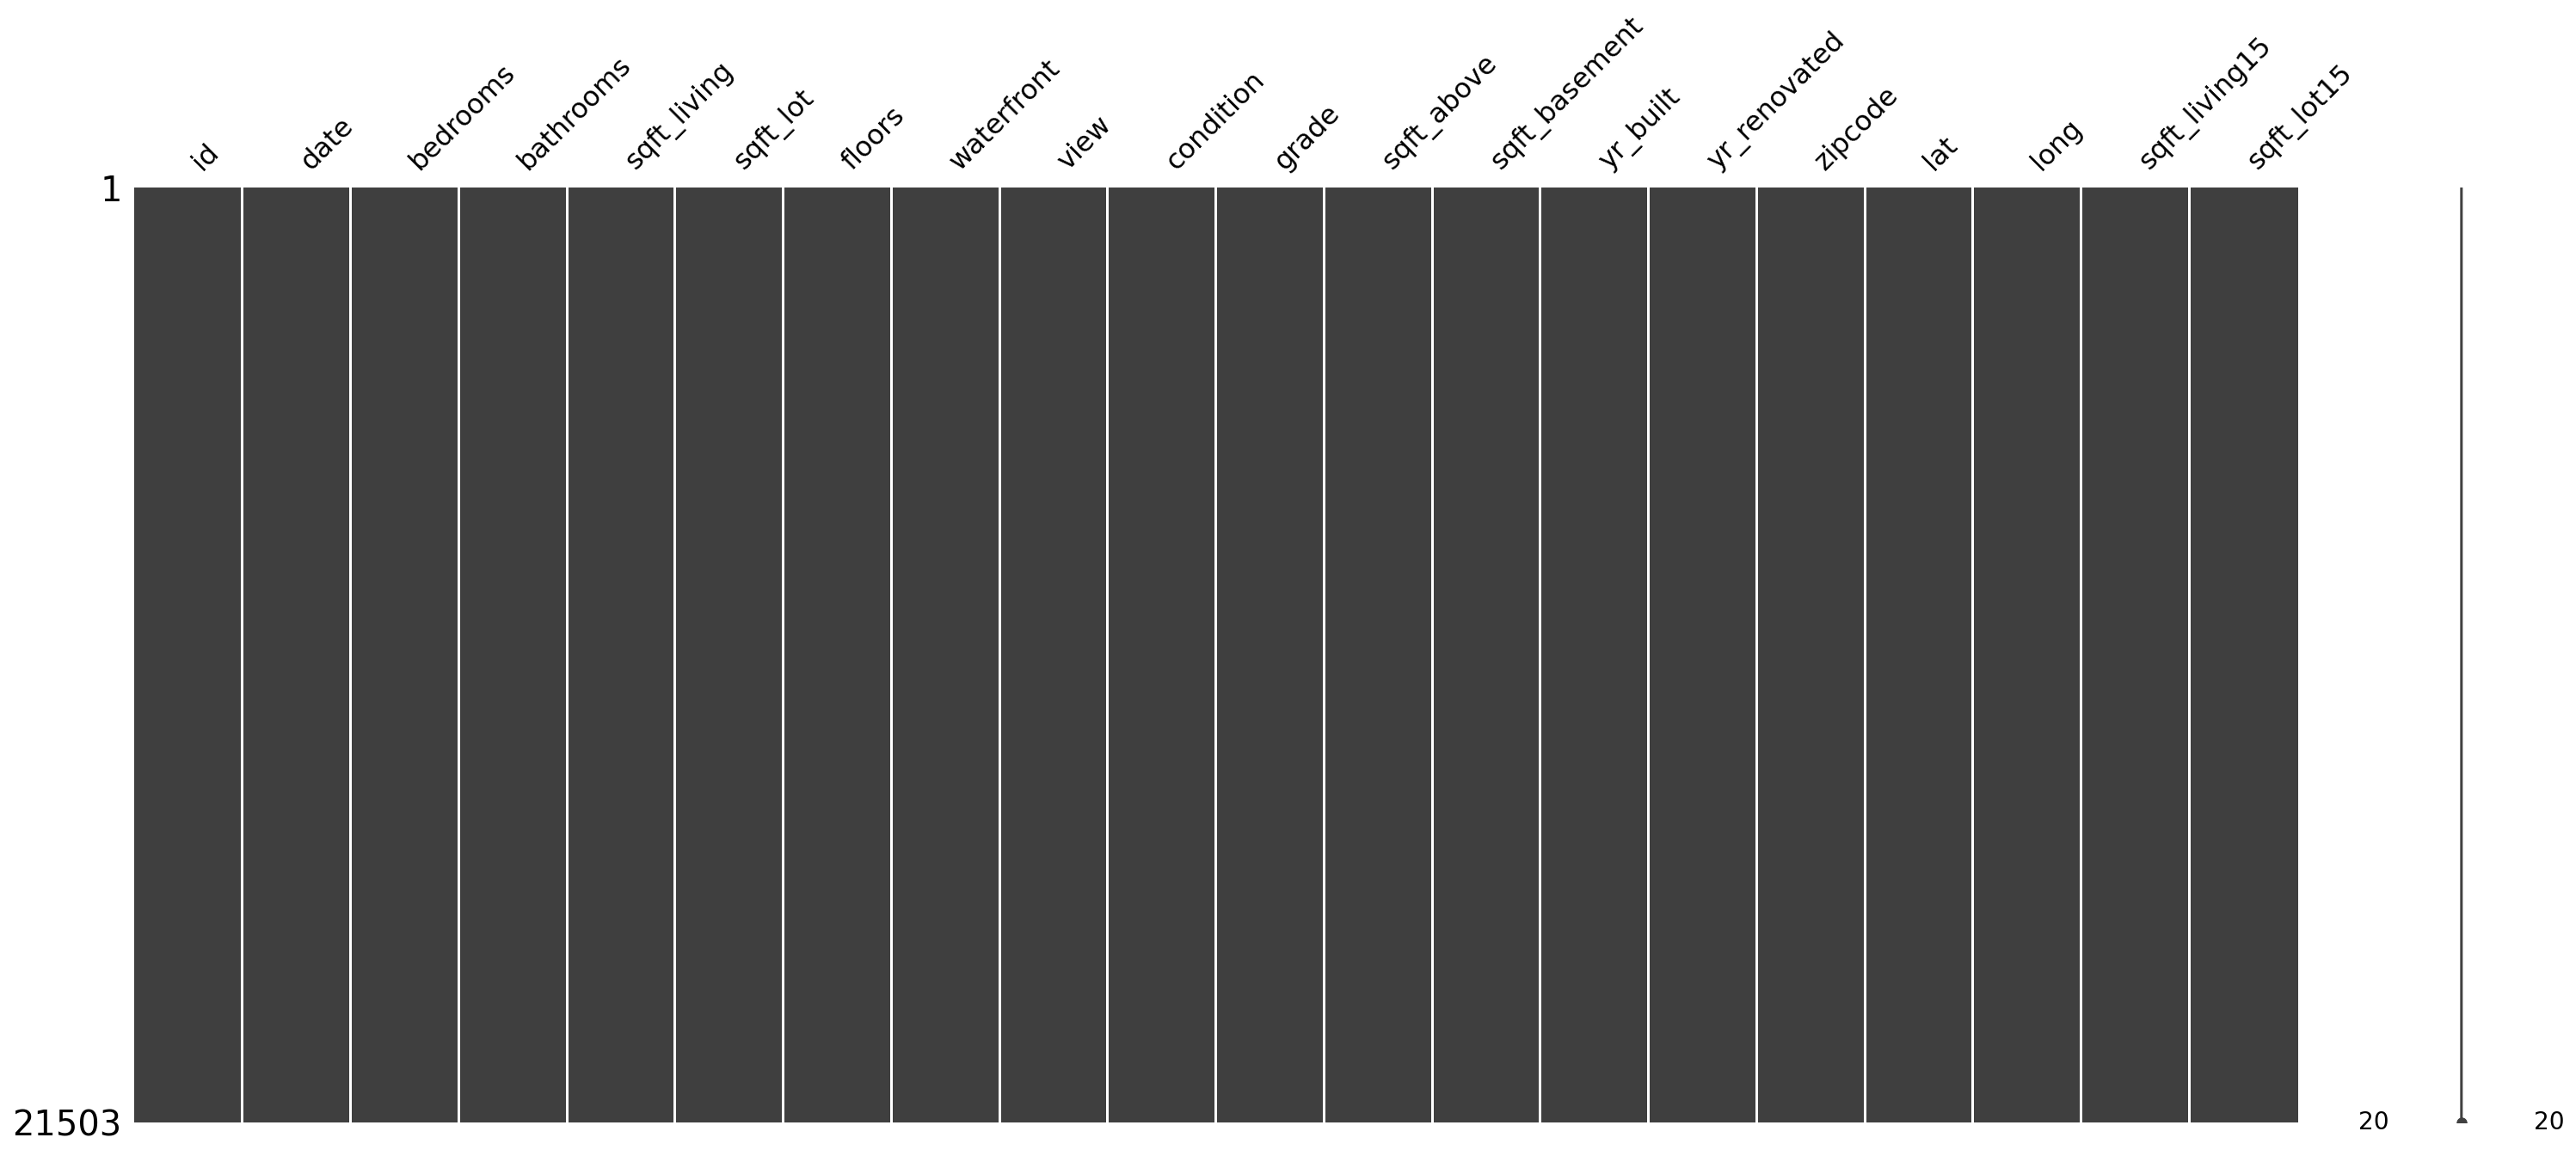

In [46]:
#missingno 라이브러리의 matrix함수는
#데이터의 결측 상태를 시각화를 통해 살펴볼수 있게 해줌
msno.matrix(data)

특정 row, col에 NaN이 있다면 해당 부분이 하얗게 나온다.

아래와 같이 직접 결측치 개수를 출력해서 확인할 수도 있다.

In [47]:
for c in data.columns:
  print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


**id, date 변수 정리**

필요없는 id 컬럼을 제거, 나중에 예측 결과를 제출할 때를 대비하여 sub_id변수에 id 칼럼을 저장하고 지우도록 한다.

In [48]:
data['id']

0           0
1           1
2           2
3           3
4           4
        ...  
6463    21498
6464    21499
6465    21500
6466    21501
6467    21502
Name: id, Length: 21503, dtype: int64

In [49]:
data['id'][train_len:]
#데이터를 합칠때, 모델링후 사용하기 위해서(데이터를 다시 나눠야함) train데이터의 길이를 train_len에 저장해 두었음

0       15035
1       15036
2       15037
3       15038
4       15039
        ...  
6463    21498
6464    21499
6465    21500
6466    21501
6467    21502
Name: id, Length: 6468, dtype: int64

In [50]:
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


date 컬럼은 apply 함수로 필요한 부분만 잘라준다.


In [51]:
data['date'].head()

0    20141013T000000
1    20150225T000000
2    20150218T000000
3    20140627T000000
4    20150115T000000
Name: date, dtype: object

In [53]:
data['date'] = data['date'].apply(lambda x : str(x[:6]))
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


여기에서 str(x[:6])으로 처리한것은 위에 형식의 데이터를 연/월만 사용하기위해 (아래처럼 바꾸기 위해서) 자른것

**각 변수들의 분포 확인**

너무 치우친 분포를 가지는 컬럼의 경우 모델이 결과를 예측하는데에 좋지 않은 영향을 미치므로 다듬는 작업 을 한다.

전체 그래프를 그려보자

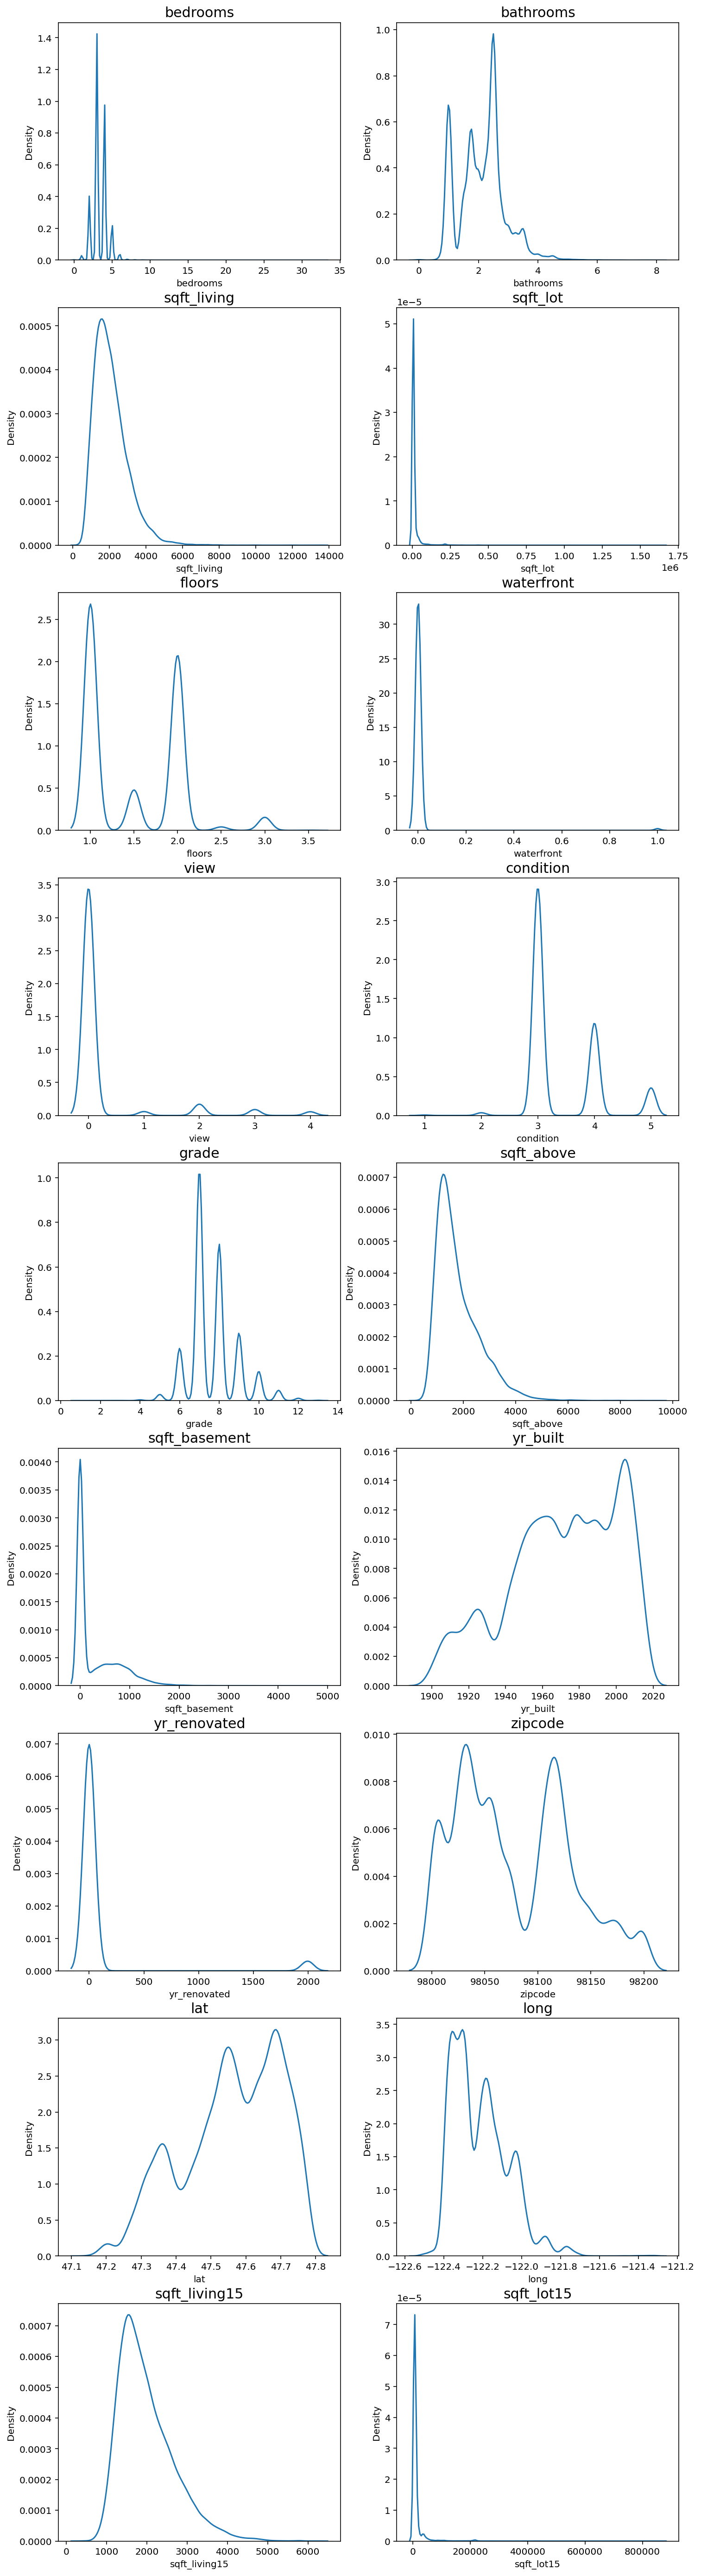

In [56]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))
#가로스크롤 떄문에 그래프 확인이 불편하면 figsize의 x값을 조절하도록
#id (count==0인 경우 )는 제외하고 분포를 확인합니다. .
count = 1
columns = data.columns
for row in range(9):
  for col in range(2):
    sns.kdeplot(data[columns[count]], ax=ax[row][col])
    ax[row][col].set_title(columns[count], fontsize=15)
    count += 1
    if count == 19 :
      break

위 그래프중 bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보임.

이렇게 한쪽으로 치우친 분포의 경우, 로그변환(log-scaling)을 통해 데이터를 정규분포에 가깝게 만들수 있다.

치우친 컬럼들을 skew_columns리스트에 담고, 모두 np.log1p()를 활용, 로그변환을 해준다.

numpy.log1p() 함수는 입력 배열의 각 요소에 대해 자연로그 log(1+x)을 반환해주는 함수이다.



In [58]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
  data[c] = np.log1p(data[c].values)

print('얍!')

얍!


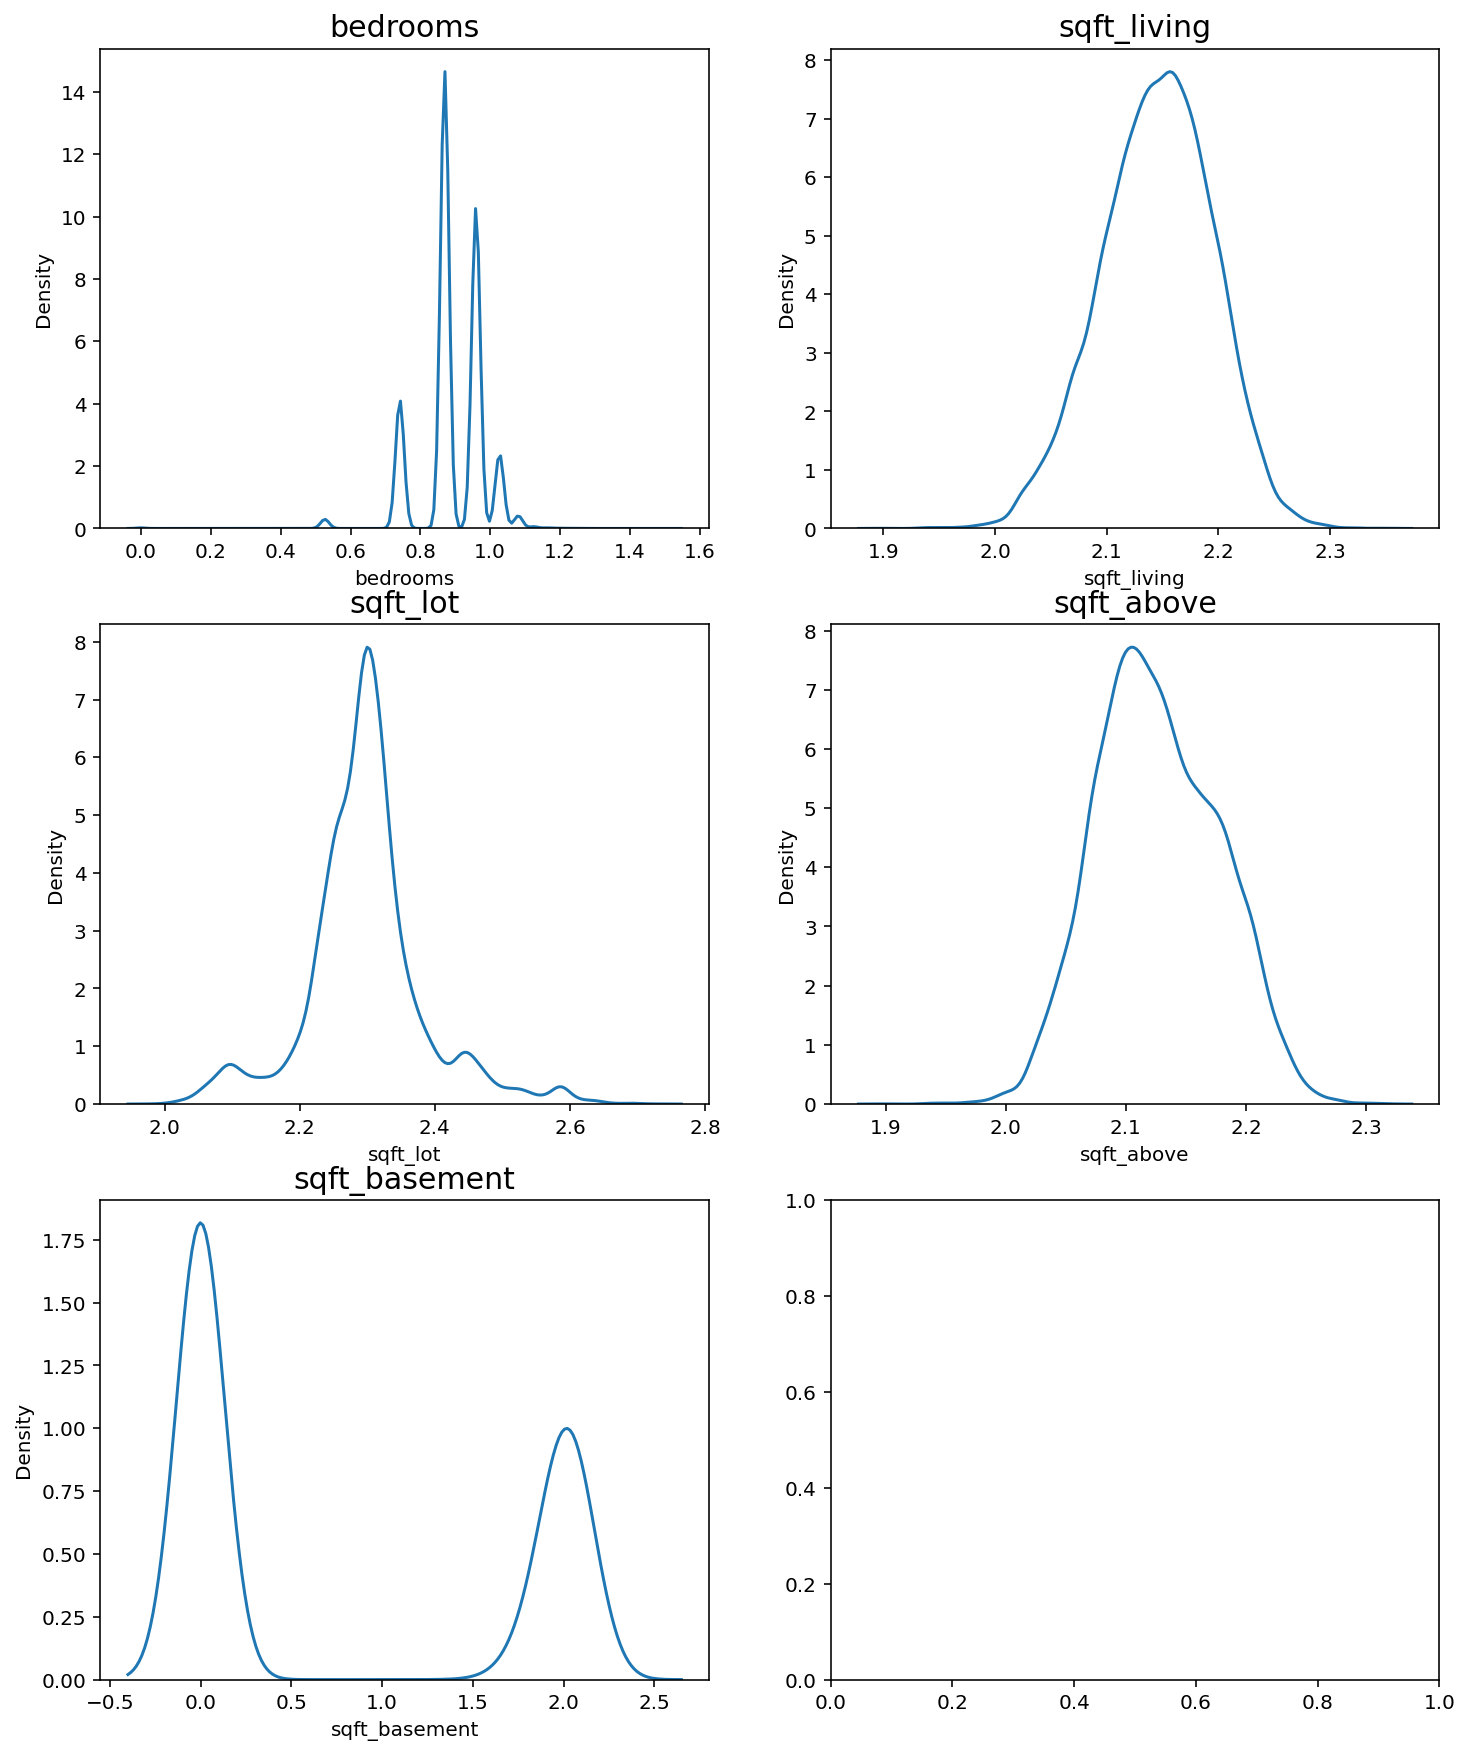

In [59]:
#변환이 된 후의 분포를 다시 확인.

fig, ax = plt.subplots(3, 2, figsize=(12, 15))

count = 0
for row in range(3):
  for col in range(2): #2중 포문이 이런 모양으로 도는구나.
    if count ==5:
      break
    sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
    ax[row][col].set_title(skew_columns[count], fontsize=15)
    count += 1

이 전보다 훨씬 치우침이 줄어듦.

** 왜 로그 변환은 분포의 치우침을 줄어들게 만들까?**

이는 로그함수의 형태를 보면 알 수 있습니다.

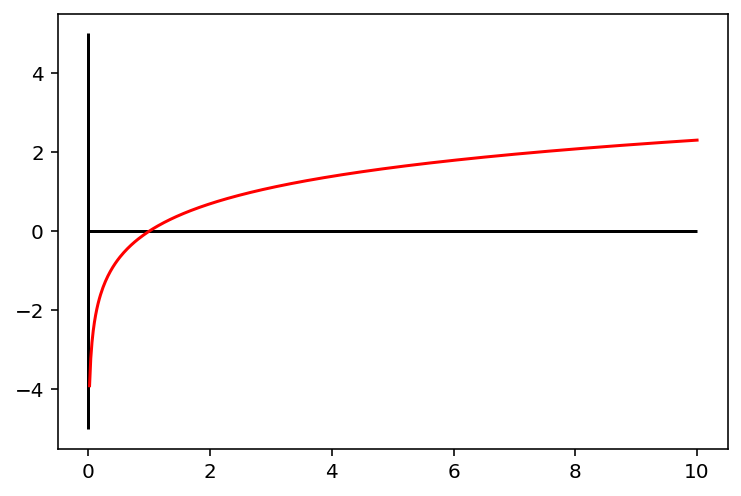

In [60]:
xx = np.linspace(0, 10, 500)
yy = np.log(xx)
plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.plot(xx, yy, c='r')
plt.show()

위와 같은 로그 함수의 특징은 다음과 같다.
- 0<x<1 범위 에서는 기울기가 매우 가파르다. 즉, x의 구간은 (0,1)로 매우 짧은 반면, y의 구간은 (-∞, 0)으로 매우 크다.

- 따라서 0에 가깝게 모여있는 값들이 x로 입력되면, 그 함수의 값인 y값들은 매우 큰 범위로 벌어지게 된다. 즉, 로그함수는 0에 가까운 값들이 조밀하게 모여있는 입력값을, 넓은 범위로 평칠 수 있는 특징을 가짐.

- 반면, x 값이 점점 커짐에 따라 로그 함수의 기울기는 급격히 작아진다.

  이는 곧 큰 x값들에 대해서는 y값이 크게 차이나지 않게 된다는 뜻이고, 따라서 넓은 범위를 가지는 x를 비교적 작은 y 값의 구간 내에 모이게 하는 특징을 가짐.
  

위와같은 특성 때문에 한쪽으로 몰려있는 분포에 로그 변환을 취하게 되면 넓게 퍼질수 있는것.

우리가 맞추어야 할 타겟 인 집의가격, 즉 data['price']의 분포를 로그변환 했을 때 결과를 유추해 보자.


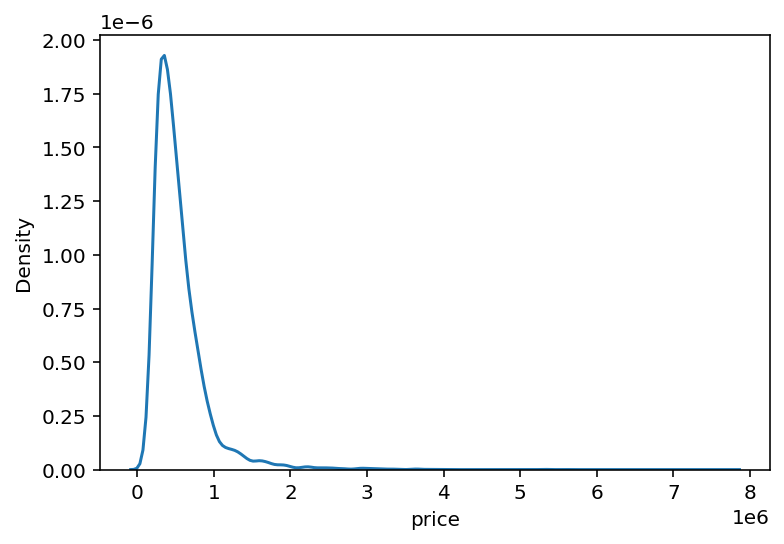

In [61]:
#원래 price의 분포
sns.kdeplot(y)
plt.show()

위 분포를 log변환 하게 되면?

위 분포는 0 쪽으로 매우 심하게 치우쳐져 있는 분포를 보인다, 즉 0과 1000000 사이에 대부분의 값들이 몰려있고, 아주 소수의 집들이 굉장히 높은 가격을 보인다.

이 분포에 로그를 취하면, 0에 가깝게 몰려있는 데이터들은 넓게 퍼질 것이고, 매우 크게 퍼져있는 소수의 데이터들은 작은 y값으로 모일 것이다.

왼쪽으로 치우친 값들은 보다 넓은 범위로 고르게 퍼지고, 오른쪽으로 얇고 넓게 퍼진 값들은 보다 작은 범위로 모여들게 되므로 전체 분포는 정규분포의 형상을 띄는 방향으로 변환됨.


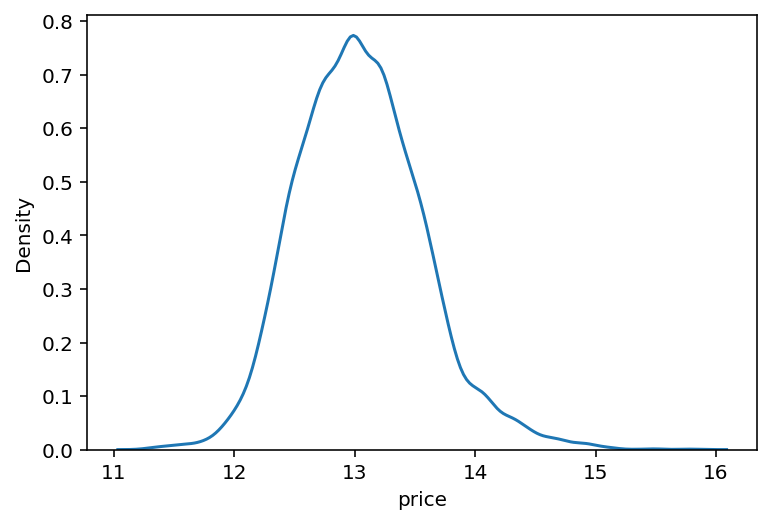

In [62]:
y_log_transformation = np.log1p(y)
sns.kdeplot(y_log_transformation)
plt.show()

직접 확인해 보니 확실히 아름다운 정규분포의 모양으로 가까워짐

로그 변환이 필요한 데이터에 대해 처리를 마무리 하였으니 데이터를 다시 나누어 준다.

위에 저장 해두었던 train_len 을 인덱스로 활용,

:train_len 까지는 학습 데이터, 즉 x에 저장

train_len: 부터는 실제로 추론을 해야하는 테스트데이터, 즉 sub 변수에 저장


In [63]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)


(15035, 19)
(6468, 19)


**모델링**

이제 학습시킬 모델을 준비합니다. Baseline 커널에서는 여러가지 모델을 함께 사용해서 결과를 섞는

**블랜딩(blending)이라는 기법을 활용

블랜딩은 하나의 개별 모델을 사용하는 것이 아니라 다양한 여러 모델을 종합하여 결과를 얻는 기법.

블렌딩은 앙상블 기법이라고 하기도 함.

    앙상블은 여러 개의 학습 알고리즘을 사용하고, 그 예측을 결합함, 보다 정확한 최종 예측을 도출하는 기법.
    하나의 강한 머신러닝 알고리즘보다, 여러개의 약한 머신러닝 알고리즘이 낫다는 아이디어로부터 시작

    앙상블 기법의 기본은 voting과 averaging 이다.
    둘 다 서로 다른 알고리즘을 가진 분류기를 결합하는 방식.
    Voting 은 여러 모델이 분류해 낸 결과들로부터 다수결 투표를 통해 최종 결과를 선택, 분류문제에서 사용
    Averaging 은 각 모델이 계산해 낸 실숫값들을 평균 혹은 가중평균하여 사용하는 방법, 회귀문제에 사용


    각 각 성능이 70%(0.7) 인 다섯개의 분류기가 있다고 가정,
    Voting 을 해 최종 결과를 결정한다면 예상 정확도는?

    다섯개의 분류기가 전부다 틀릴 확률은 0.3^5 = 0.0024

    하나만 맞고, 네 개가 틀릴 확률은 5C_1 * 0.3^4 * 0.7 = 0.0284

    두개, 세개 5C_2 * 0.3^3 * 0.7 = 0.1323

    세개 두개 5C_3 * 0.3^2 * 0.7 = 0.3087

    네개, 한개 5C_4 * 0.3 * 0.7 = 